Baseline (mean predictor) performance on test set:
R²:   -0.0001
RMSE: 1.5593
MAE:  0.7920

Model performance comparison table (R², RMSE, MAE, and training time):

                name        r2      rmse       mae  train_time
0  Linear Regression  0.118250  1.464113  0.742237    0.152797
1      Random Forest  0.198792  1.395643  0.694681    0.258521
2  Gradient Boosting  0.322727  1.283169  0.632691    0.473484

Random Forest with base features:
R²:   0.1988
RMSE: 1.3956
MAE:  0.6947

Random Forest with engineered features:
R²:   0.1793
RMSE: 1.4126
MAE:  0.7034



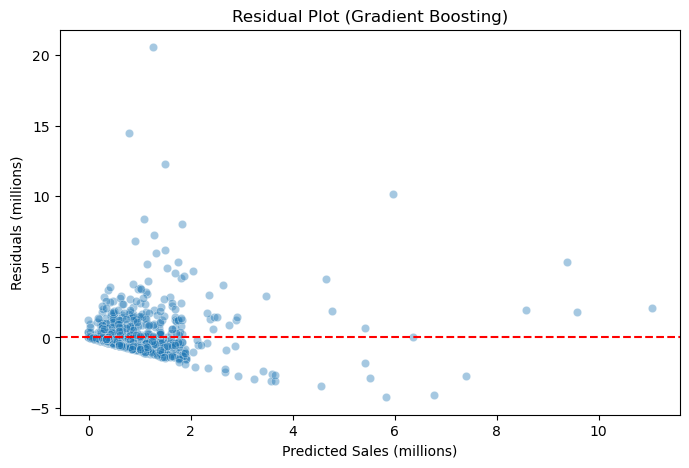

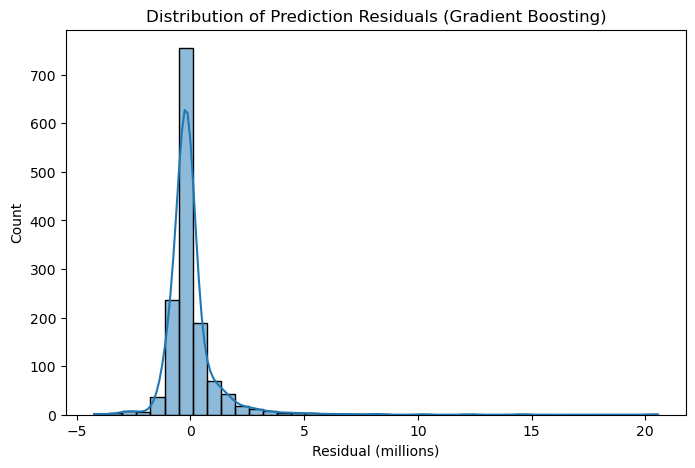

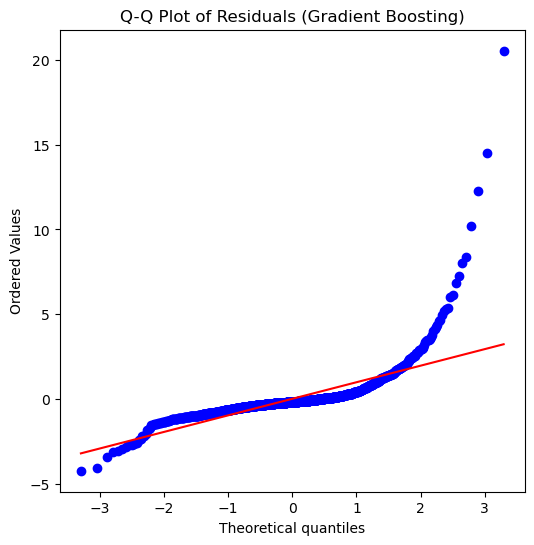

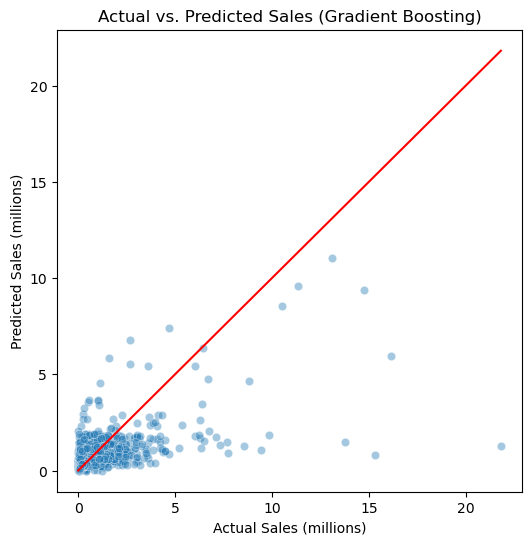


Cross-validation results (mean ± std for R² and RMSE):

                    R2_mean    R2_std  RMSE_mean  RMSE_std
Linear Regression  0.080981  0.038114   1.819366  0.456586
Random Forest     -0.101240  0.307544   1.964726  0.495455
Gradient Boosting  0.157263  0.094881   1.745355  0.475424



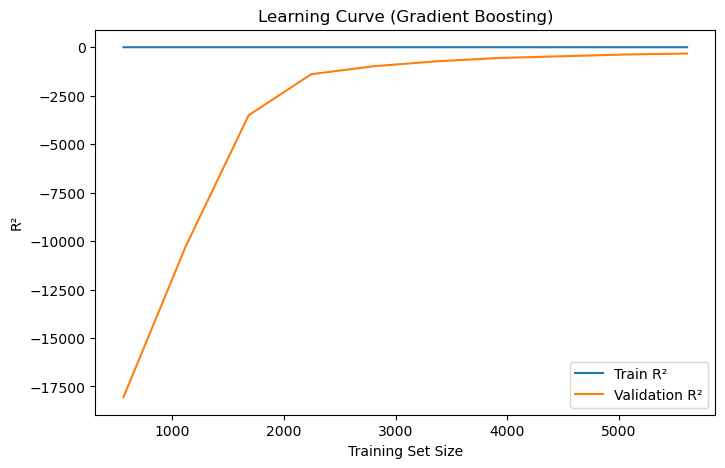


Gradient Boosting Feature Importances:

Critic_Score          0.619106
User_Score            0.220889
Genre_Shooter         0.041163
Genre_Racing          0.040231
Genre_Misc            0.018904
Genre_Strategy        0.015487
Genre_Sports          0.015014
Genre_Platform        0.011609
Genre_Fighting        0.010517
Genre_Adventure       0.003421
Genre_Role-Playing    0.002071
Genre_Simulation      0.001413
Genre_Puzzle          0.000176
dtype: float64


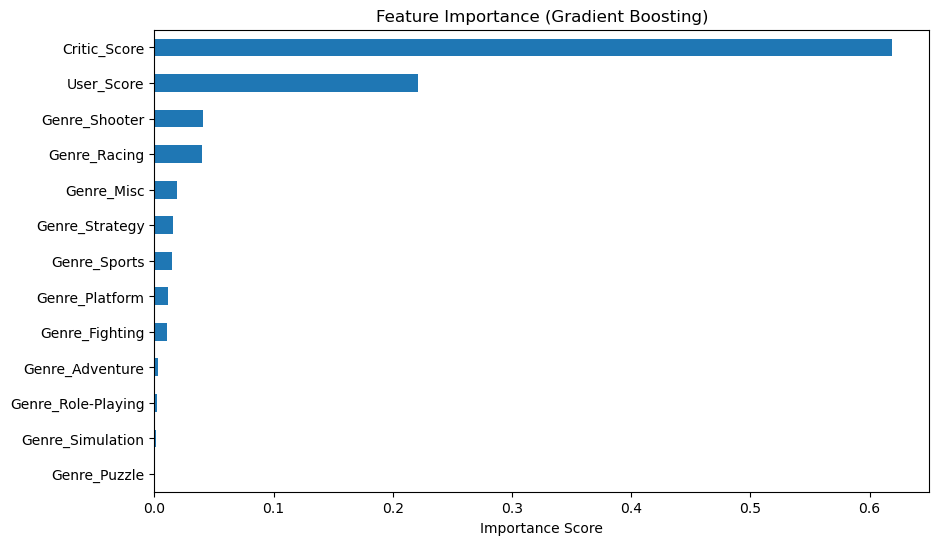


Permutation Importances:

Critic_Score          0.725571
User_Score            0.128653
Genre_Shooter         0.019194
Genre_Strategy        0.012070
Genre_Misc            0.010904
Genre_Sports          0.007688
Genre_Adventure       0.001433
Genre_Fighting        0.000883
Genre_Racing          0.000408
Genre_Simulation      0.000077
Genre_Puzzle          0.000035
Genre_Role-Playing   -0.001503
Genre_Platform       -0.002106
dtype: float64

Top 10 Worst Prediction Errors:

    Actual  Predicted   Residual
8    21.81   1.266415  20.543585
15   15.29   0.788409  14.501591
19   13.79   1.498116  12.291884
14   16.15   5.965958  10.184042
45    9.44   1.089575   8.350425
41    9.86   1.838448   8.021552
51    8.57   1.287652   7.282348
59    7.72   0.901782   6.818218
61    7.66   1.498116   6.161884
65    7.32   1.313526   6.006474

Residual Statistics by Genre:

                  mean    median       std
Genre                                     
Action        0.069147 -0.136284  1.0956

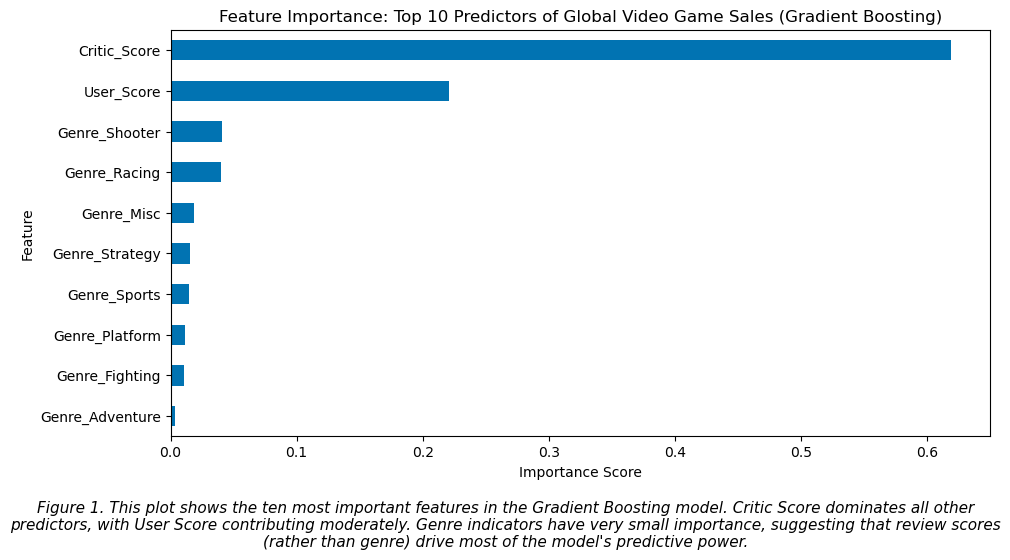

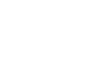

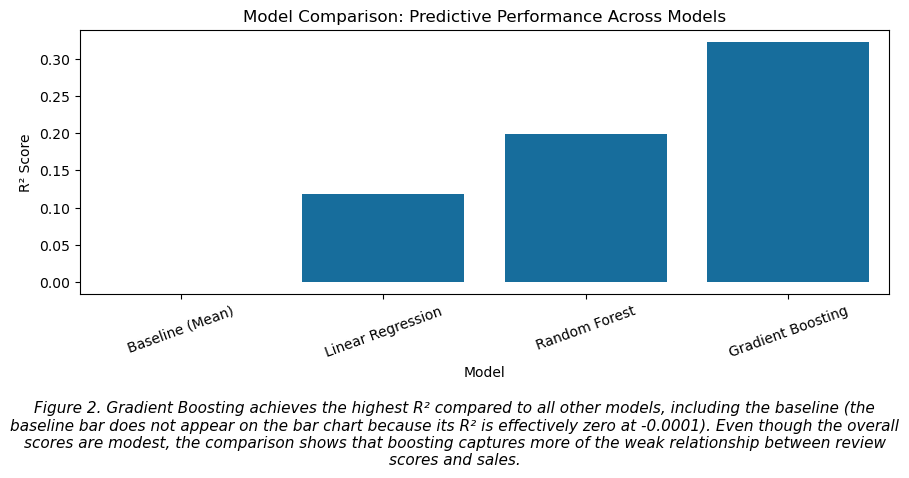

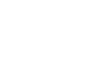

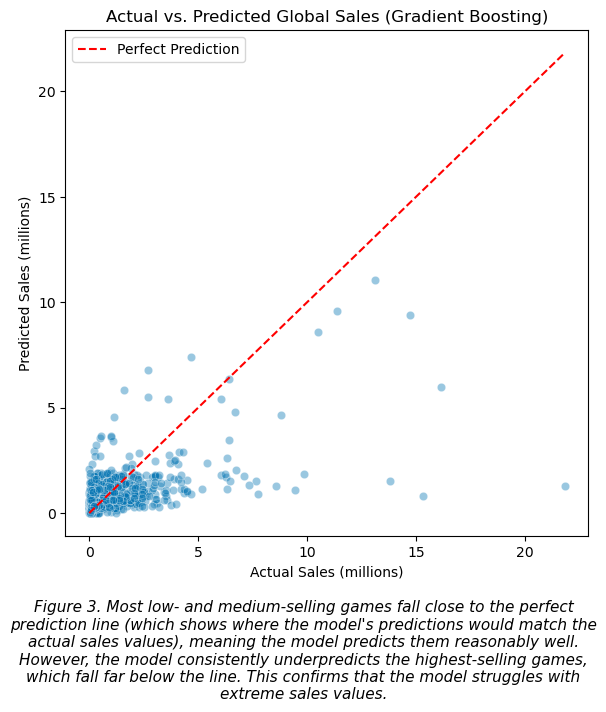

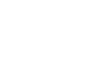

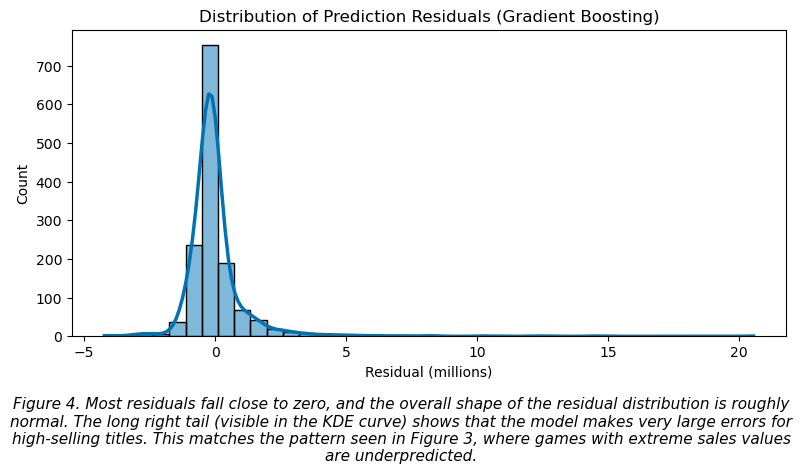

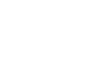

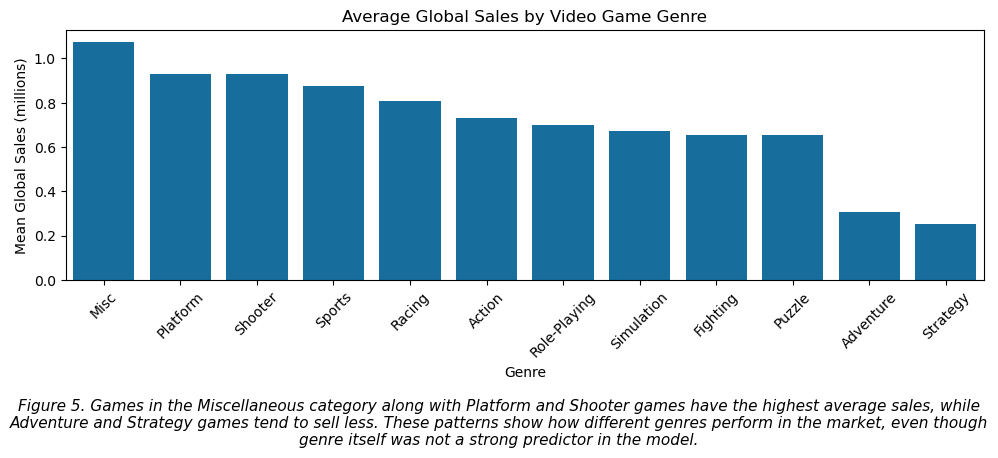

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Importing cleaned dataset
cleaned_df = pd.read_csv("https://raw.githubusercontent.com/seamusgsullivan/Video-Game-Ratings-Sales-and-Genre-Analysis/main/data/processed/Cleaned_Video_Games_Sales_as_at_22_Dec_2016.csv")

# Remember, each entry/row in the dataset represents a single video game title released on a specific platform, as explained in the Sprint 2 report in the Unit of Analysis section.
# For example, "FIFA 14" on Xbox 360 and "FIFA 14" on PlayStation 3 are recorded as separate entries in the dataset. 
# So when I say "games", I really mean "individual game/platform entries". I just say "games" for convenience!

# --------------------------------------
# Baseline Model
# --------------------------------------

# Features and target
X = cleaned_df[['Critic_Score', 'User_Score', 'Genre']]
y = cleaned_df['Global_Sales']

# One-hot encode Genre
X = pd.get_dummies(X, columns=['Genre'], drop_first=True)

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model: predict mean of training Global_Sales
baseline_pred_value = y_train.mean()
y_pred_baseline = np.full(shape=y_test.shape, fill_value=baseline_pred_value)

# Baseline metrics
baseline_r2 = r2_score(y_test, y_pred_baseline)

baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(baseline_mse)

baseline_mae = mean_absolute_error(y_test, y_pred_baseline)

print("Baseline (mean predictor) performance on test set:")
print(f"R²:   {baseline_r2:.4f}")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE:  {baseline_mae:.4f}")

# --------------------------------------
# Primary Model(s) + Model Comparison
# --------------------------------------

# Helper function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    mae = mean_absolute_error(y_test, y_pred)

    return {
        "model": model,
        "r2": r2,
        "rmse": rmse,
        "mae": mae,
        "train_time": train_time
    }

# Define models
lin_reg = LinearRegression()

rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)

gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)

# Train and evaluate each model
results = []
for name, model in [
    ("Linear Regression", lin_reg),
    ("Random Forest", rf),
    ("Gradient Boosting", gbr)
]:
    metrics = train_and_evaluate(model, X_train, X_test, y_train, y_test)
    metrics["name"] = name
    results.append(metrics)

# Show results as a small table
results_df = pd.DataFrame(results)[["name", "r2", "rmse", "mae", "train_time"]]
print("\nModel performance comparison table (R², RMSE, MAE, and training time):\n")
print(results_df)

# --------------------------------------
# Feature Engineering (Advanced)
# --------------------------------------

# Start from the original cleaned_df again
fe_df = cleaned_df.copy()

# Create engineered features
fe_df["Avg_Score"] = (fe_df["Critic_Score"] + fe_df["User_Score"]) / 2.0
fe_df["Score_Diff"] = fe_df["Critic_Score"] - fe_df["User_Score"]

# Base feature set (no engineered features)
X_base = fe_df[['Critic_Score', 'User_Score', 'Genre']]
X_base = pd.get_dummies(X_base, columns=['Genre'], drop_first=True)

# Extended feature set (with engineered features)
X_fe = fe_df[['Critic_Score', 'User_Score', 'Avg_Score', 'Score_Diff', 'Genre']]
X_fe = pd.get_dummies(X_fe, columns=['Genre'], drop_first=True)

y_fe = fe_df['Global_Sales']

# Train/test split for both setups (same random_state and test_size)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y_fe, test_size=0.2, random_state=42)

Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

# Random Forest with base features
rf_base = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
base_metrics = train_and_evaluate(rf_base, Xb_train, Xb_test, yb_train, yb_test)
print("\nRandom Forest with base features:")
print(f"R²:   {base_metrics['r2']:.4f}")
print(f"RMSE: {base_metrics['rmse']:.4f}")
print(f"MAE:  {base_metrics['mae']:.4f}")

# Random Forest with engineered features
rf_fe = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
fe_metrics = train_and_evaluate(rf_fe, Xf_train, Xf_test, yf_train, yf_test)
print("\nRandom Forest with engineered features:")
print(f"R²:   {fe_metrics['r2']:.4f}")
print(f"RMSE: {fe_metrics['rmse']:.4f}")
print(f"MAE:  {fe_metrics['mae']:.4f}")
print()



# --------------------------------------
# Regression Diagnostics
# --------------------------------------

# Re-fit main models for diagnostics (already trained above, but keeping in same structure)

# Predictions for diagnostics
y_pred_lr = lin_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gbr = gbr.predict(X_test)

# Residuals for Gradient Boosting (best model)
residuals = y_test - y_pred_gbr

# Residual Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_gbr, y=residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sales (millions)")
plt.ylabel("Residuals (millions)")
plt.title("Residual Plot (Gradient Boosting)")
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribution of Prediction Residuals (Gradient Boosting)")
plt.xlabel("Residual (millions)")
plt.show()

# Q–Q Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Gradient Boosting)")
plt.show()

# Actual vs. Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_gbr, alpha=0.4)
plt.xlabel("Actual Sales (millions)")
plt.ylabel("Predicted Sales (millions)")
plt.title("Actual vs. Predicted Sales (Gradient Boosting)")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red')
plt.show()

# --------------------------------------
# Cross-Validation & Generalization
# --------------------------------------

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Linear Regression": lin_reg,
    "Random Forest": rf,
    "Gradient Boosting": gbr
}

cv_results = {}

for name, model in models.items():
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    rmse_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error")
    cv_results[name] = {
        "R2_mean": r2_scores.mean(),
        "R2_std": r2_scores.std(),
        "RMSE_mean": rmse_scores.mean(),
        "RMSE_std": rmse_scores.std()
    }

print("\nCross-validation results (mean ± std for R² and RMSE):\n")
print(pd.DataFrame(cv_results).T)
print()

# Learning Curve (Gradient Boosting)
train_sizes, train_scores, test_scores = learning_curve(
    gbr, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring="r2"
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Train R²")
plt.plot(train_sizes, test_mean, label="Validation R²")
plt.xlabel("Training Set Size")
plt.ylabel("R²")
plt.title("Learning Curve (Gradient Boosting)")
plt.legend()
plt.show()

# --------------------------------------
# Feature Importance & Interpretability
# --------------------------------------

# Gradient Boosting Feature Importance
gbr_importances = pd.Series(gbr.feature_importances_, index=X.columns)

print("\nGradient Boosting Feature Importances:\n")
print(gbr_importances.sort_values(ascending=False))

# Plot feature importance
plt.figure(figsize=(10,6))
gbr_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.show()

# Permutation Importance
from sklearn.inspection import permutation_importance

perm = permutation_importance(gbr, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns)

print("\nPermutation Importances:\n")
print(perm_importances.sort_values(ascending=False))

# --------------------------------------
# Error Analysis & Failure Modes
# --------------------------------------

# Combine predictions and residuals
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_gbr,
    'Residual': residuals
})

# 10 largest errors
worst_errors = errors.reindex(errors['Residual'].abs().sort_values(ascending=False).index)[:10]

print("\nTop 10 Worst Prediction Errors:\n")
print(worst_errors)

# Error distribution by genre
X_test_with_errors = X_test.copy()
X_test_with_errors['Residual'] = residuals
X_test_with_errors['Genre'] = cleaned_df.loc[X_test.index, 'Genre']

genre_error_stats = X_test_with_errors.groupby("Genre")['Residual'].agg(['mean', 'median', 'std'])

print("\nResidual Statistics by Genre:\n")
print(genre_error_stats)
print()



# --------------------------------------
# Results & Interpretation: Visualizations
# --------------------------------------

sns.set_palette("colorblind")

# =====================================================
# FIGURE 1 - Feature Importance (Top Predictors)
# =====================================================

top_importances = gbr_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance: Top 10 Predictors of Global Video Game Sales (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.figtext(
    0.5, -0.10,
    "Figure 1. This plot shows the ten most important features in the Gradient Boosting model. "
    "Critic Score dominates all other predictors, with User Score contributing moderately. "
    "Genre indicators have very small importance, suggesting that review scores (rather than genre) drive most of the model's predictive power.",
    wrap=True, ha='center', fontsize=11, style='italic'
)

plt.tight_layout()
plt.show()

# Add spacing between figures
plt.figure(figsize=(1,0.5))
plt.axis('off')
plt.show()

# =====================================================
# FIGURE 2 - Model Comparison (R² Scores)
# =====================================================

# Build comparison_df from results_df by adding the baseline
comparison_df = results_df.copy()

baseline_row = pd.DataFrame([{
    "name": "Baseline (Mean)",
    "r2": baseline_r2,
    "rmse": baseline_rmse,
    "mae": baseline_mae,
    "train_time": 0.0
}])

comparison_df = pd.concat([baseline_row, comparison_df], ignore_index=True)

plt.figure(figsize=(9,4))
sns.barplot(data=comparison_df, x="name", y="r2")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.title("Model Comparison: Predictive Performance Across Models")
plt.xticks(rotation=20)

plt.figtext(
    0.5, -0.17,
    "Figure 2. Gradient Boosting achieves the highest R² compared to all other models, including the baseline "
    "(the baseline bar does not appear on the bar chart because its R² is effectively zero at -0.0001). "
    "Even though the overall scores are modest, the comparison shows that boosting captures more of the weak relationship between review scores and sales.",
    wrap=True, ha='center', fontsize=11, style='italic'
)

plt.tight_layout()
plt.show()

# Add spacing between figures
plt.figure(figsize=(1,0.5))
plt.axis('off')
plt.show()

# =====================================================
# FIGURE 3 - Actual vs. Predicted Scatterplot
# =====================================================

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_gbr, alpha=0.4)
plt.plot([0, y_test.max()], [0, y_test.max()], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual Sales (millions)")
plt.ylabel("Predicted Sales (millions)")
plt.title("Actual vs. Predicted Global Sales (Gradient Boosting)")
plt.legend()

plt.figtext(
    0.5, -0.17,
    "Figure 3. Most low- and medium-selling games fall close to the perfect prediction line (which shows where the model's predictions would match the actual sales values), " 
    "meaning the model predicts them reasonably well. "
    "However, the model consistently underpredicts the highest-selling games, which fall far below the line. "
    "This confirms that the model struggles with extreme sales values.",
    wrap=True, ha='center', fontsize=11, style='italic'
)

plt.tight_layout()
plt.show()

# Add spacing between figures
plt.figure(figsize=(1,0.5))
plt.axis('off')
plt.show()

# =====================================================
# FIGURE 4 - Distribution of Residuals
# =====================================================

plt.figure(figsize=(8,4))
ax = sns.histplot(residuals, bins=40, kde=True)

kde_line = ax.lines[-1]
kde_line.set_linewidth(2.5)

plt.xlabel("Residual (millions)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Residuals (Gradient Boosting)")

plt.figtext(
    0.5, -0.16,
    "Figure 4. Most residuals fall close to zero, and the overall shape of the residual distribution is roughly normal. "
    "The long right tail (visible in the KDE curve) shows that the model makes very large errors for high-selling titles. "
    "This matches the pattern seen in Figure 3, where games with extreme sales values are underpredicted.",
    wrap=True, ha='center', fontsize=11, style='italic'
)

plt.tight_layout()
plt.show()

# Add spacing between figures
plt.figure(figsize=(1,0.5))
plt.axis('off')
plt.show()

# =====================================================
# FIGURE 5 - Domain-Relevant: Mean Global Sales by Genre
# =====================================================

genre_means = cleaned_df.groupby("Genre")["Global_Sales"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x=genre_means.index, y=genre_means.values)
plt.xlabel("Genre")
plt.ylabel("Mean Global Sales (millions)")
plt.title("Average Global Sales by Video Game Genre")
plt.xticks(rotation=45)

plt.figtext(
    0.5, -0.12,
    "Figure 5. Games in the Miscellaneous category along with Platform and Shooter games have the highest average sales, while Adventure and Strategy games tend to sell less. "
    "These patterns show how different genres perform in the market, even though genre itself was not a strong predictor in the model.",
    wrap=True, ha='center', fontsize=11, style='italic'
)

plt.tight_layout()
plt.show()